<a href="https://colab.research.google.com/github/AfrifaEben7/Notebook_Projects/blob/main/Traffic_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Beyond Human Performance

# 5.0.1. Initial setup

### import dependencies

In [ ]:
# Let us first import the necessary libraries
import numpy as np                                       # for linear algebra
import tensorflow as tf                                  # for neural models
import matplotlib.pyplot as plt                          # for plotting data
import time                                              # for measuring time
import zipfile                                           # for handling zip archives
import PIL                                               # for image handling
from keras import backend as K

In [ ]:
!gdown https://drive.google.com/uc?export=download&id=1rL7ZSIQsDAV11dcOT4mSYSZDHyY9bW5Q
import eplabtools as eplab

Downloading...
From: https://drive.google.com/uc?export=download
To: /content/uc?export=download
1.69kB [00:00, 3.60MB/s]


### get data

In [ ]:
# Next we will download and unzip the "GTSRB 40x40" dataset
!gdown https://drive.google.com/uc?export=download&id=1l-Fs3aG7C0nLa-vm7B6Xiiy55PjDrJfI
local_zip = '/content/drive/MyDrive/ADAS/GTSRB_40x40.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

Downloading...
From: https://drive.google.com/uc?export=download
To: /content/uc?export=download
1.69kB [00:00, 4.39MB/s]


In [ ]:
# Let's introduce some definitions
IMG_SIZE = (40, 40)
IMG_SHAPE = (40, 40, 3)
NOF_CLASSES = 43

TRAIN_SET_PATH = '/content/GTSRB_40x40/training_set_40x40'
TRAIN_SET_SIZE = 39209
TRAIN_BATCH_SIZE = 256

DEV_RATIO = 0.1             # 3920 dev images are enough
DEV_BATCH_SIZE = 256

TEST_SET_PATH = '/content/GTSRB_40x40/test_set_40x40'
TEST_SET_SIZE = 12630
TEST_BATCH_SIZE = 256

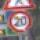

In [ ]:
# original img
img_arr = np.array(PIL.Image.open('/content/GTSRB_40x40/training_set_40x40/00000/00000_00000.ppm'))
eplab.showarray(img_arr)

In [ ]:
# Flow training images in batches using train_datagen generator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=DEV_RATIO)

train_generator = train_datagen.flow_from_directory(
    TRAIN_SET_PATH,
    target_size=IMG_SIZE,
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='sparse',
    subset='training') # set as training data

dev_generator = train_datagen.flow_from_directory(
    TRAIN_SET_PATH,
    target_size=IMG_SIZE,
    batch_size=DEV_BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    subset='validation') # set as dev data

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_SET_PATH,
    target_size=IMG_SIZE,
    batch_size=TEST_BATCH_SIZE,
    class_mode='sparse',
    shuffle=False)

Found 35289 images belonging to 43 classes.
Found 3920 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


In [ ]:
augmented_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255, validation_split=DEV_RATIO,
                                           rotation_range=15,
                                           width_shift_range=0.3,
                                           height_shift_range=0.3,
                                           shear_range=0.2,
                                           zoom_range=[0.8, 1.5],
                                           horizontal_flip=False,
                                           vertical_flip=False,
                                           fill_mode='nearest',
                                           data_format='channels_last',
                                           brightness_range=[0.5, 1.5])


augmented_train_generator = augmented_train_datagen.flow_from_directory(
    TRAIN_SET_PATH,
    target_size=IMG_SIZE,
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='sparse',
    subset='training') # set as training data

augmented_dev_generator = augmented_train_datagen.flow_from_directory(
    TRAIN_SET_PATH,
    target_size=IMG_SIZE,
    batch_size=DEV_BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    subset='validation') # set as dev data

augmented_test_generator = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255,
                                           rotation_range=15,
                                           width_shift_range=0.3,
                                           height_shift_range=0.3,
                                           shear_range=0.2,
                                           zoom_range=[0.8, 1.5],
                                           horizontal_flip=False,
                                           vertical_flip=False,
                                           fill_mode='nearest',
                                           data_format='channels_last',
                                           brightness_range=[0.5, 1.5]).flow_from_directory(
    TEST_SET_PATH,
    target_size=IMG_SIZE,
    batch_size=TEST_BATCH_SIZE,
    class_mode='sparse',
    shuffle=False)

Found 35289 images belonging to 43 classes.
Found 3920 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


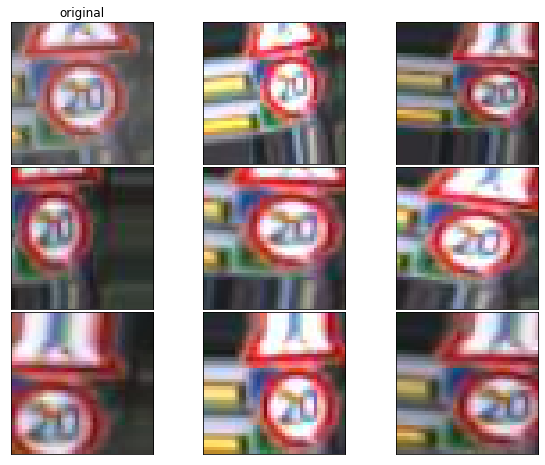

In [ ]:
orig_img = tf.keras.preprocessing.image.load_img("/content/GTSRB_40x40/training_set_40x40/00000/00000_00000.ppm")
eplab.augment_plot_pics(augmented_train_datagen, orig_img)

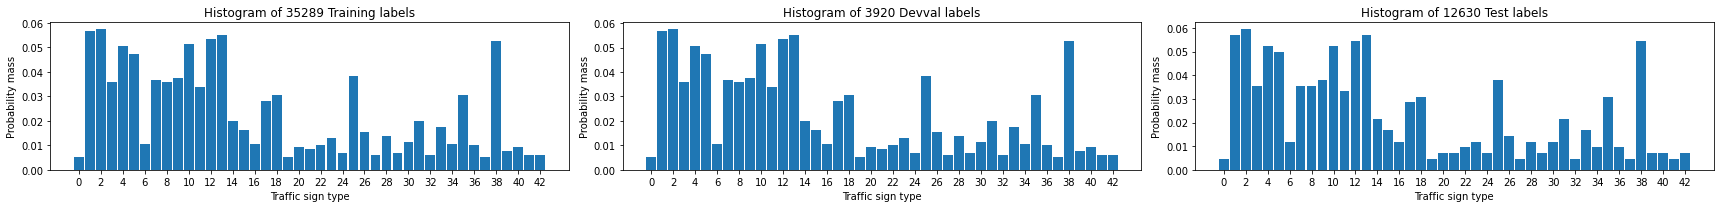

In [ ]:
# Let's see a histogram of the categories
bins = np.arange(-0.5, 43, 1)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,3))

# the histogram of the data
for ax, setname, setlabels in zip(axs,
                                  ['Training', 'Devval', 'Test'],
                                  [train_generator.labels, dev_generator.labels, test_generator.labels]):
    ax.hist(setlabels, bins=bins, density=True, rwidth=0.9)
    ax.set_xlabel('Traffic sign type')
    ax.set_xticks(np.arange(0, 43, 2))
    ax.set_ylabel('Probability mass')
    ax.set_title(f'Histogram of {setlabels.size} {setname} labels')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

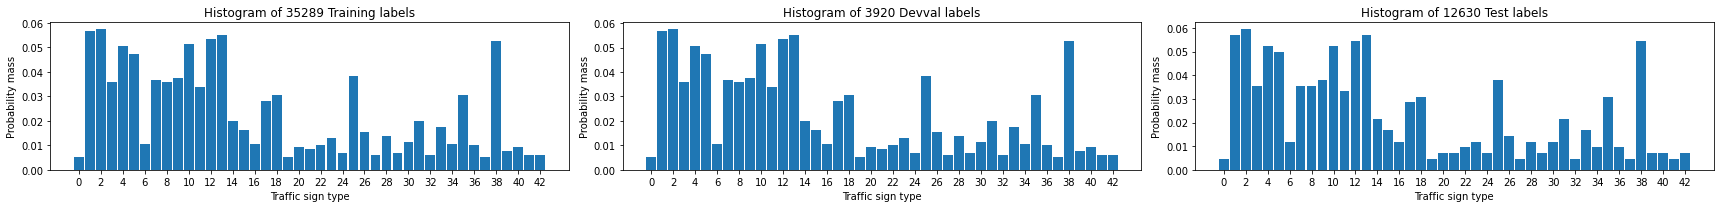

In [ ]:
# Let's see a histogram of the AUGMENTED categories
bins = np.arange(-0.5, 43, 1)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,3))

# the histogram of the data
for ax, setname, setlabels in zip(axs,
                                  ['Training', 'Devval', 'Test'],
                                  [augmented_train_generator.labels, augmented_dev_generator.labels, augmented_test_generator.labels]):
    ax.hist(setlabels, bins=bins, density=True, rwidth=0.9)
    ax.set_xlabel('Traffic sign type')
    ax.set_xticks(np.arange(0, 43, 2))
    ax.set_ylabel('Probability mass')
    ax.set_title(f'Histogram of {setlabels.size} {setname} labels')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

# 5.1. Convolutional Neural Network (CNN)

In [ ]:
# Define the model
def build_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=IMG_SHAPE, name='LAYER_01_cnv'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', name='LAYER_02_cnv'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', name='LAYER_03_cnv'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu', name='LAYER_04_cnv'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu', name='LAYER_05_fc'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(rate=0.75),
        tf.keras.layers.Dense(NOF_CLASSES, activation='softmax', name='LAYER_06_fc')
    ])

    model.summary()

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=0.001),
                  metrics=['acc'])
    return model

In [ ]:
model = build_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LAYER_01_cnv (Conv2D)       (None, 38, 38, 64)        1792      
                                                                 
 batch_normalization_5 (Batc  (None, 38, 38, 64)       256       
 hNormalization)                                                 
                                                                 
 LAYER_02_cnv (Conv2D)       (None, 36, 36, 64)        36928     
                                                                 
 batch_normalization_6 (Batc  (None, 36, 36, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                      

In [ ]:
history = model.fit_generator(
    augmented_train_generator,
    steps_per_epoch = augmented_train_generator.samples // TRAIN_BATCH_SIZE,
    validation_data = augmented_dev_generator,
    validation_steps = augmented_dev_generator.samples // DEV_BATCH_SIZE,
    epochs=40,
    verbose=1,
    shuffle=True)

<ipython-input-32-41db3f93a99e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
137/137 [==============================] - 47s 335ms/step - loss: 3.7512 - acc: 0.0601 - val_loss: 3.5654 - val_acc: 0.0510
Epoch 2/40
137/137 [==============================] - 45s 325ms/step - loss: 3.4971 - acc: 0.0763 - val_loss: 3.4742 - val_acc: 0.0648
Epoch 3/40
137/137 [==============================] - 44s 324ms/step - loss: 3.4380 - acc: 0.0788 - val_loss: 3.3884 - val_acc: 0.1003
Epoch 4/40
137/137 [==============================] - 44s 323ms/step - loss: 3.4124 - acc: 0.0815 - val_loss: 3.3609 - val_acc: 0.1099
Epoch 5/40
137/137 [==============================] - 45s 332ms/step - loss: 3.3934 - acc: 0.0794 - val_loss: 3.3280 - val_acc: 0.1214
Epoch 6/40
137/137 [==============================] - 44s 324ms/step - loss: 3.3833 - acc: 0.0808 - val_loss: 3.3362 - val_acc: 0.1115
Epoch 7/40
137/137 [==============================] - 45s 330ms/step - loss: 3.3811 - acc: 0.0792 - val_loss: 3.3245 - val_acc: 0.1187
Epoch 8/40
137/137 [==============================] - 4

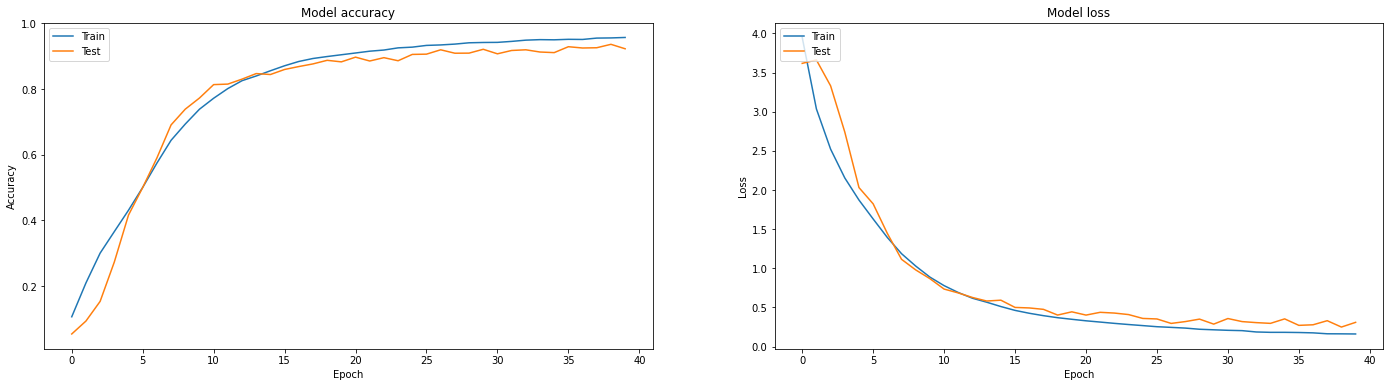

In [ ]:
eplab.plot_history(history)

In [ ]:
# devval performance
model.evaluate_generator(
    dev_generator,
    steps = dev_generator.samples // TEST_BATCH_SIZE
)

<ipython-input-24-587ea2957d79>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(


[0.11086761951446533, 0.964062511920929]

In [ ]:
# FREEZING LAYERS for transfer learning (transfer from augmented to original distribution)
def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False
    for layer in model.layers[-4:]:
        layer.trainable = True

    model.layers[-2].rate = 0.0  # lessened dropout rate

    model.compile(loss='sparse_categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=0.001),
                    metrics=['acc'])

In [ ]:
# Freee model
freeze_model(model)

In [ ]:
# transfer learn
historyTR = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // TRAIN_BATCH_SIZE,
    validation_data = dev_generator,
    validation_steps = dev_generator.samples // DEV_BATCH_SIZE,
    epochs=15,
    verbose=1,
    shuffle=True)

Epoch 1/15


<ipython-input-27-740a4cc53127>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historyTR = model.fit_generator(


137/137 [==============================] - 10s 69ms/step - loss: 0.0044 - acc: 0.9990 - val_loss: 0.1149 - val_acc: 0.9682
Epoch 2/15
137/137 [==============================] - 9s 65ms/step - loss: 5.4743e-04 - acc: 1.0000 - val_loss: 0.1012 - val_acc: 0.9714
Epoch 3/15
137/137 [==============================] - 9s 65ms/step - loss: 2.3113e-04 - acc: 1.0000 - val_loss: 0.0955 - val_acc: 0.9727
Epoch 4/15
137/137 [==============================] - 9s 64ms/step - loss: 1.5704e-04 - acc: 1.0000 - val_loss: 0.0937 - val_acc: 0.9734
Epoch 5/15
137/137 [==============================] - 10s 74ms/step - loss: 1.1807e-04 - acc: 1.0000 - val_loss: 0.0941 - val_acc: 0.9734
Epoch 6/15
137/137 [==============================] - 9s 64ms/step - loss: 8.9957e-05 - acc: 1.0000 - val_loss: 0.0937 - val_acc: 0.9737
Epoch 7/15
137/137 [==============================] - 9s 64ms/step - loss: 7.4487e-05 - acc: 1.0000 - val_loss: 0.0941 - val_acc: 0.9740
Epoch 8/15
137/137 [==============================] - 

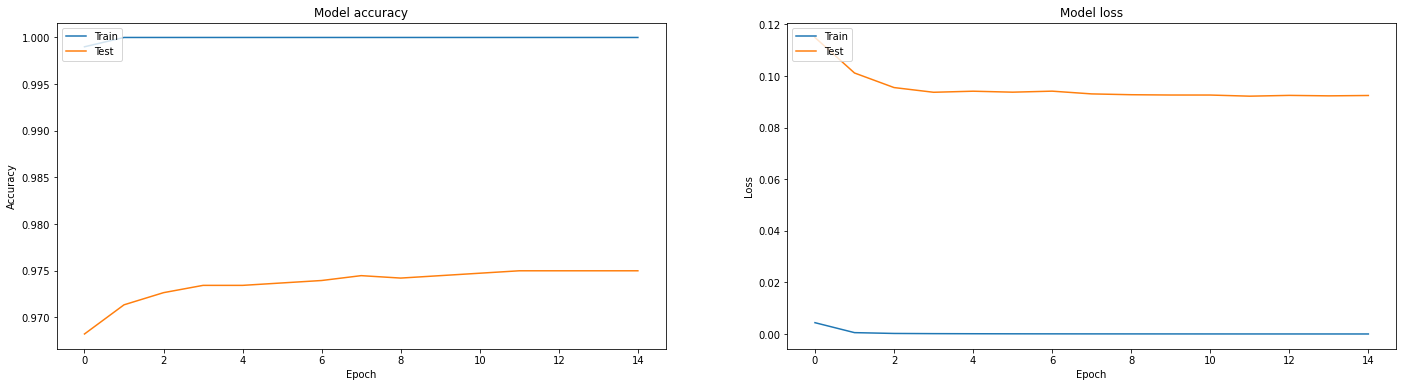

In [ ]:
eplab.plot_history(historyTR)

### Final test


In [ ]:
# test performance
model.evaluate_generator(
    test_generator,
    steps = test_generator.samples // TEST_BATCH_SIZE
)

<ipython-input-29-35927ab3864a>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(


[0.08454744517803192, 0.9759247303009033]

### Visualizing the convolutions

[ 1. 12. 26.  9.  1. 18.  3.  7. 10. 27.]
1/1 [==============================] - 0s 15ms/step


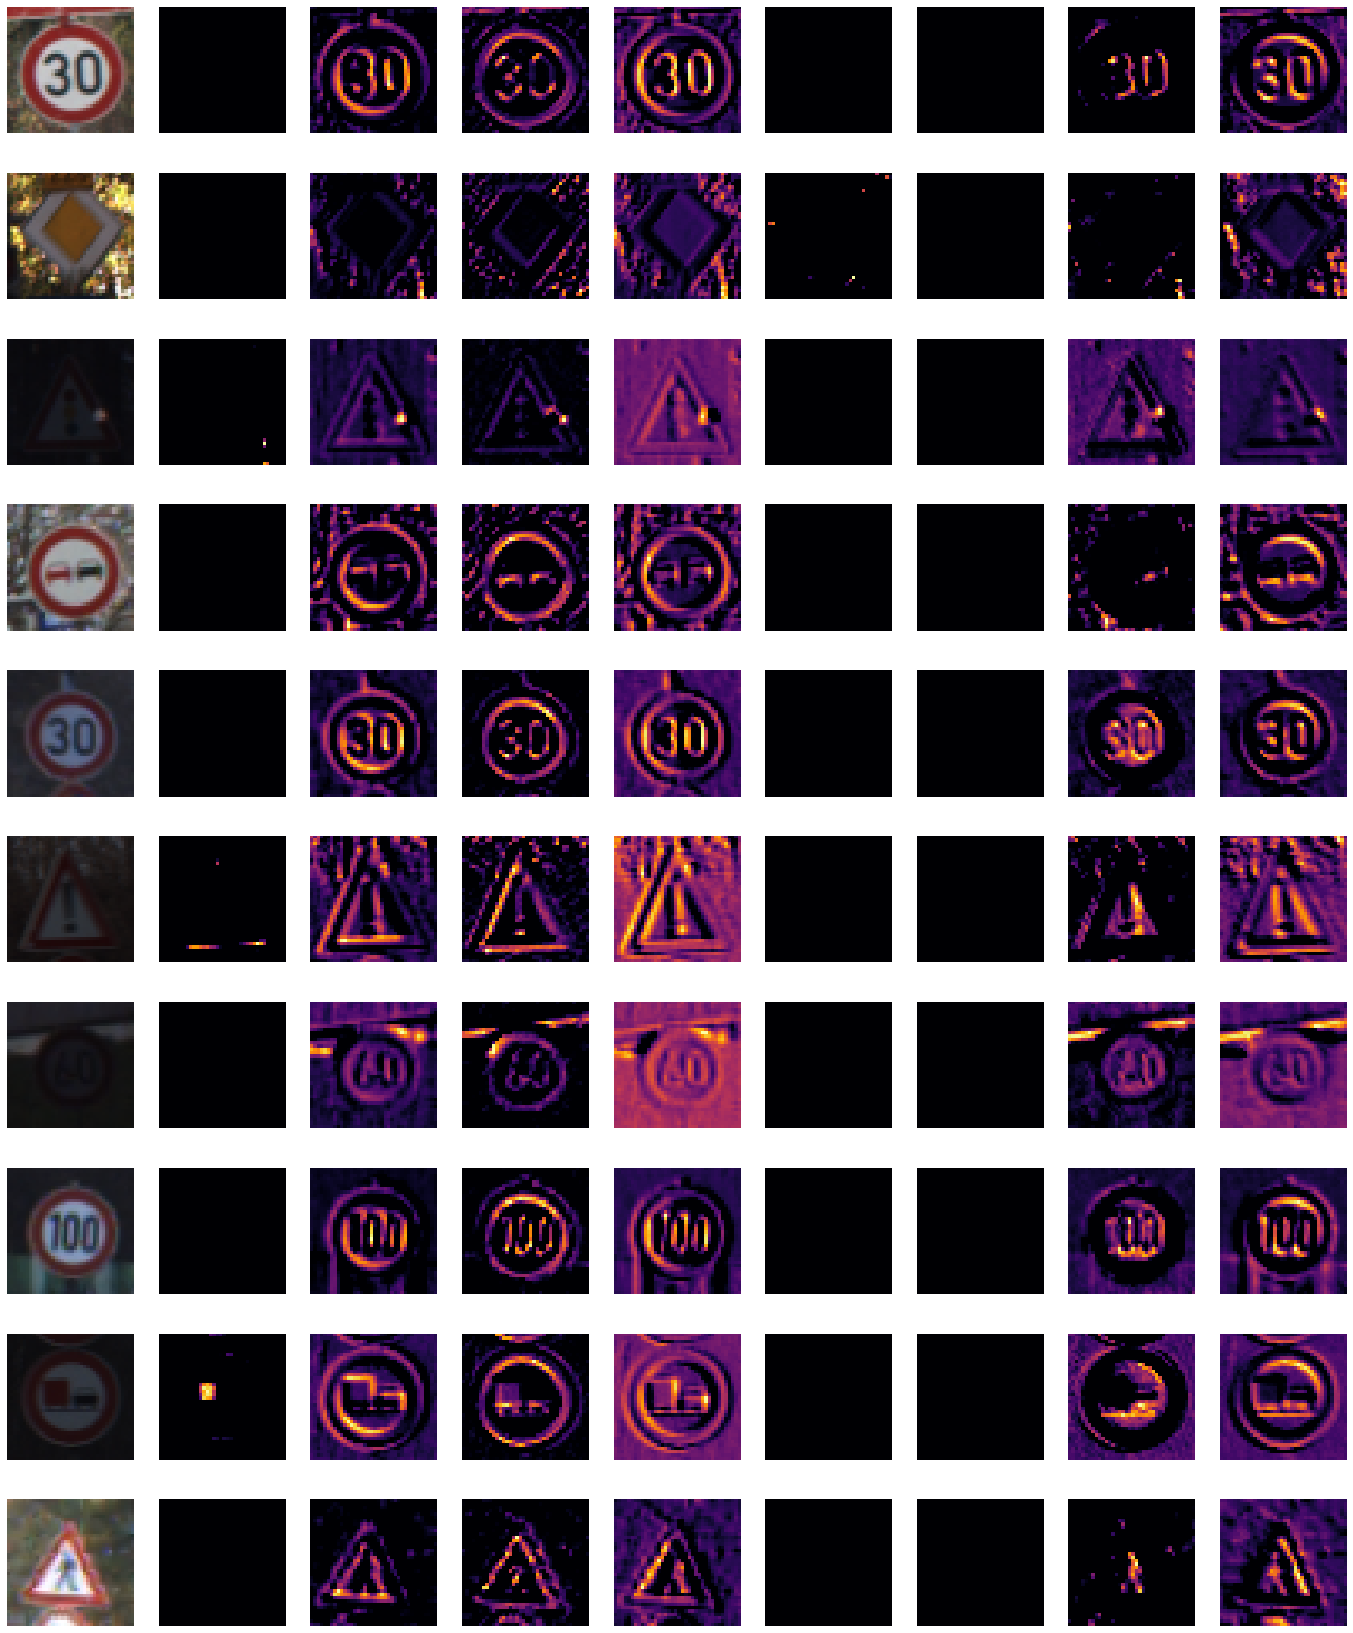

In [ ]:
nof_try_images = 10
try_images = train_generator.__getitem__(0)[0][:nof_try_images]
try_labels = train_generator.__getitem__(0)[1][:nof_try_images]
print(try_labels)
eplab.plot_convs(model, try_images, layernum=0)